# Analyse ROMY Events - Montenegro

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import multitaper

from obspy.clients.fdsn import Client


In [2]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill
from functions.compute_backazimuth import __compute_backazimuth
from functions.makeplot_waveform_comparison_cc import __makeplot_waveform_comparison_cc
from functions.makeplot_comparison_ccf import __makeplot_comparison_ccf
from functions.get_event_info import __get_event_info
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform
from functions.compute_cwt import __compute_cwt

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

## path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

## Event
config['tbeg'] = obs.UTCDateTime("2024-03-14 03:06")
config['tend'] = obs.UTCDateTime("2024-03-14 03:36")


config['event_name'] = "Montenegro"

config['filename'] = f"ROMY_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"

config['Client'] = Client("USGS")

## ROMY coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941



## Load Data

In [5]:
config, dist, baz, az = __get_event_info(config)

Event:	2024-03-14T03:06:46.795000Z | +42.994,  +18.680 | 5.4  mww | manual

	            resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000mirj&format=quakeml")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='us', creation_time=UTCDateTime(2024, 3, 15, 15, 21, 4, 101000))
	    preferred_origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us6000mirj/us/1710386705040/product.xml")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us6000mirj/us/1710386705040/product.xml#magnitude")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements
Distance  814.170164034937 m Azimuth  317.4325644063705 Backazimuth  132.135491589739


In [6]:
st0 = obs.read(config['path_to_data']+config['filename'])

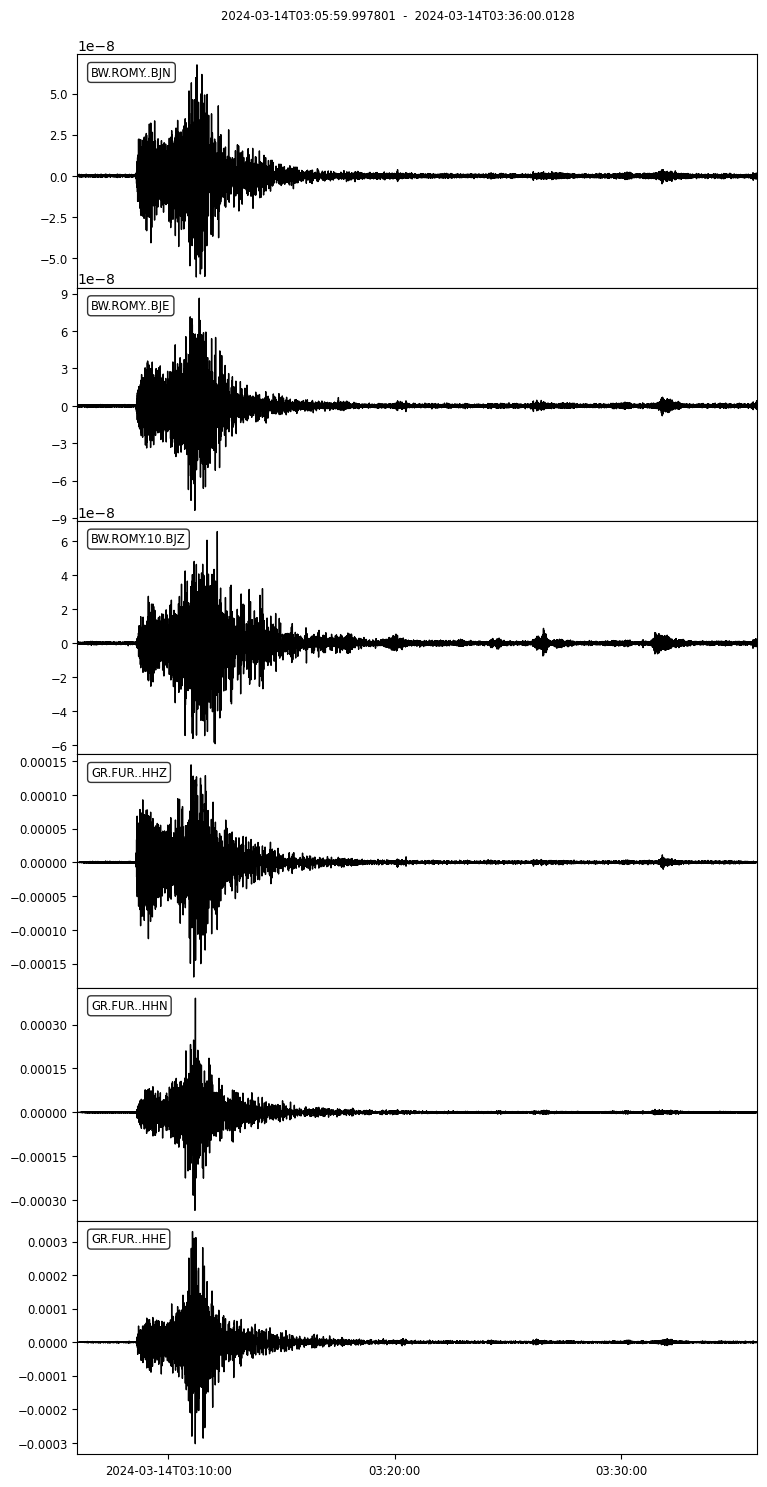

In [7]:
st0.plot(equal_scale=False);

In [8]:
dt1, dt2 = 120, 1000
st0 = st0.trim(config['tbeg']+dt1, config['tend']-dt2)


## Spectra

In [9]:
def __makeplot_waveform_comparison(bspf, adr, submask):

    from obspy.signal.cross_correlation import correlate

    fig, ax = plt.subplots(3, 1, figsize=(15, 5))

    font = 14

    ax[0].plot(bspf.select(channel="*Z")[0].times(), bspf.select(channel="*Z")[0].data, label="BSPF Z")
    ax[0].plot(adr.select(channel="*Z")[0].times(), adr.select(channel="*Z")[0].data, label="ADR Z")

    ax[1].plot(bspf.select(channel="*N")[0].times(), bspf.select(channel="*N")[0].data, label="BSPF N")
    ax[1].plot(adr.select(channel="*N")[0].times(), adr.select(channel="*N")[0].data, label="ADR N")

    ax[2].plot(bspf.select(channel="*E")[0].times(), bspf.select(channel="*E")[0].data, label="BSPF E")
    ax[2].plot(adr.select(channel="*E")[0].times(), adr.select(channel="*E")[0].data, label="ADR E")

    cc_Z = round(correlate(bspf.select(channel="*Z")[0].data, adr.select(channel="*Z")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)
    cc_N = round(correlate(bspf.select(channel="*N")[0].data, adr.select(channel="*N")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)
    cc_E = round(correlate(bspf.select(channel="*E")[0].data, adr.select(channel="*E")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel("rot. rate (rad/s)")

    ax[2].set_xlabel("Frequency (Hz)")
    ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CCz = {cc_Z} | CCn = {cc_N} | CCe = {cc_E}")

    plt.show();
    return fig

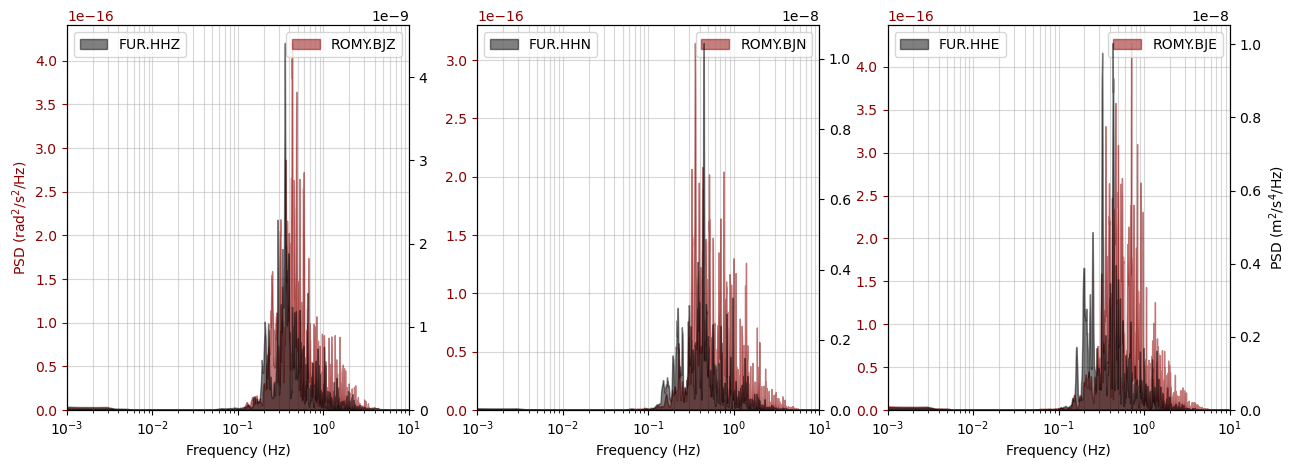

In [10]:

acc0 = st0.select(station="FUR*", channel="*H*").copy()
rot0 = st0.select(station="ROMY", channel="*J*").copy()

rot0 = rot0.detrend("simple")
acc0 = acc0.detrend("simple")

fig = __makeplot_spectra_comparison_fill(rot0, acc0, fmin=0.001, fmax=10, ylog=False, xlog=True, fill=True)

fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_spectra_all.png", format="png", dpi=150, bbox_inches='tight');


### Continueous Wavelet Transform

set frequency limit: 10


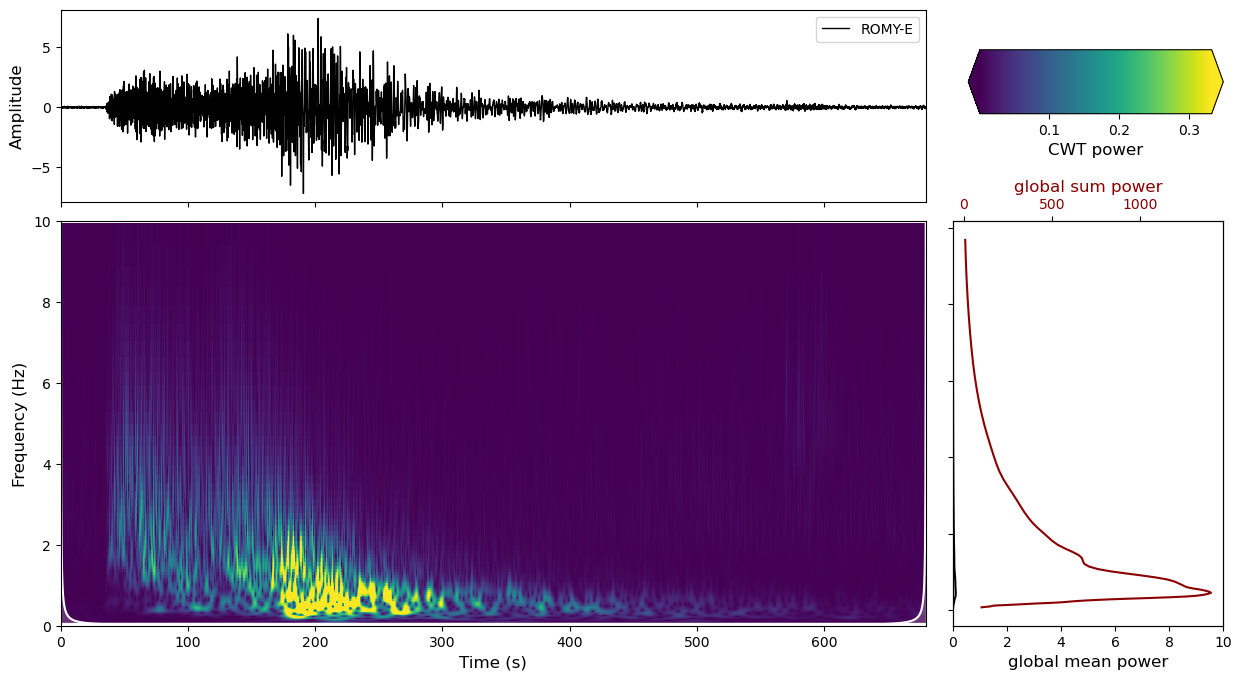

set frequency limit: 10


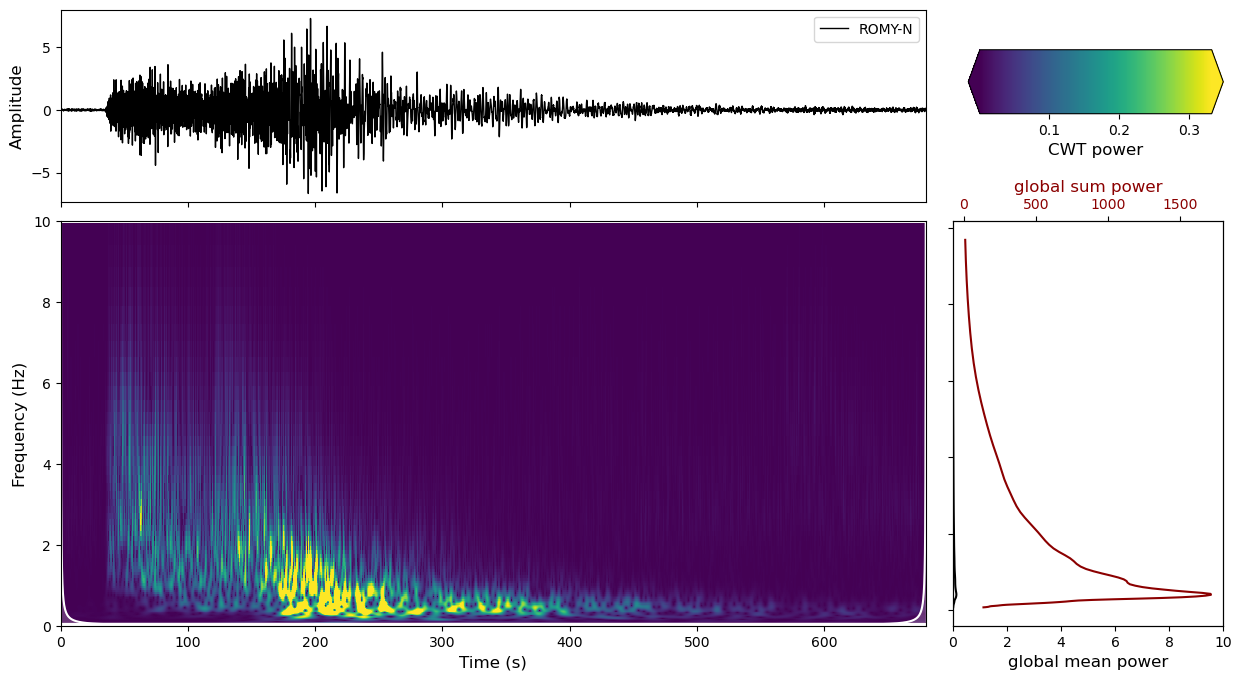

set frequency limit: 10


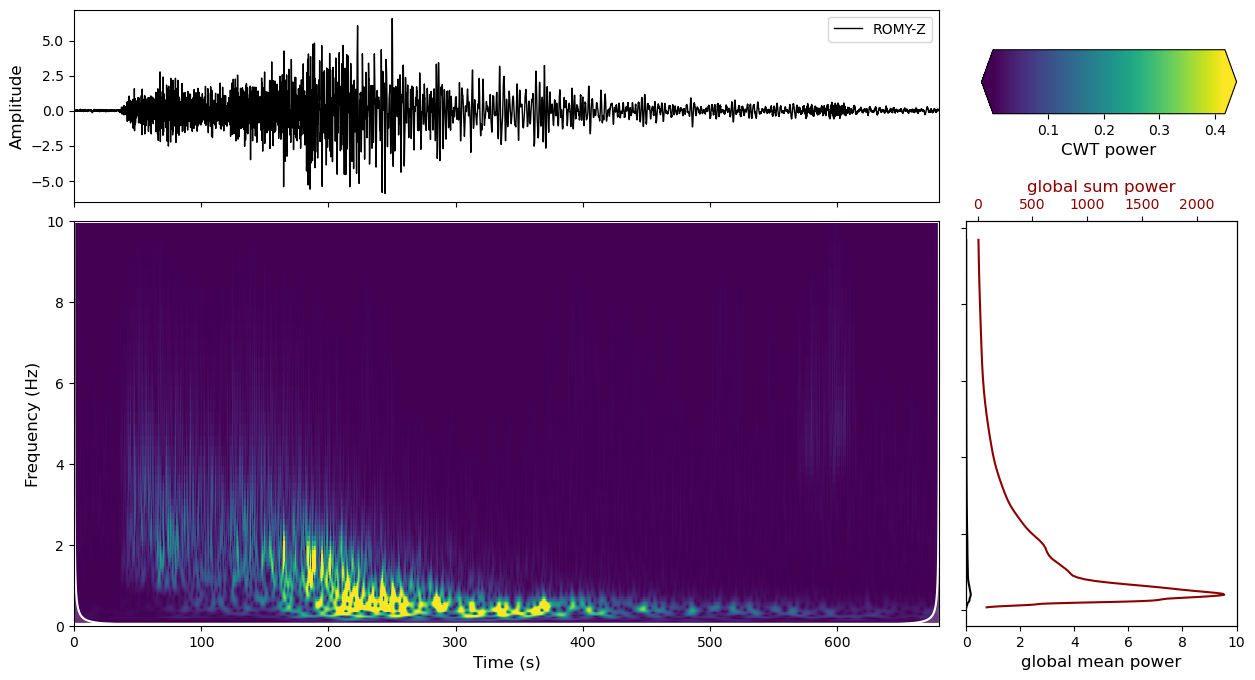

In [13]:
for component in ["E", "N", "Z"]:

    ttt = rot0[0].times()
    arr = rot0.select(channel=f"*{component}")[0].data
    dt = rot0[0].stats.delta # seconds

    out = __compute_cwt(ttt, arr, dt, tscale="sec",
                        datalabel=f"ROMY-{component}",
                        period=False,
                        ymax=10,
                        plot=True,
                       )

    out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_cwt_{component}.png",
                       format="png", dpi=150, bbox_inches='tight');


### Cross Wavelet Transform

/home/andbro/notebooks/RomyEvents/functions/compute_cross_wavelet_transform.py:164: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[3].set_xlim(0, ymax)
/home/andbro/notebooks/RomyEvents/functions/compute_cross_wavelet_transform.py:165: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[2].set_ylim(0, ymax)


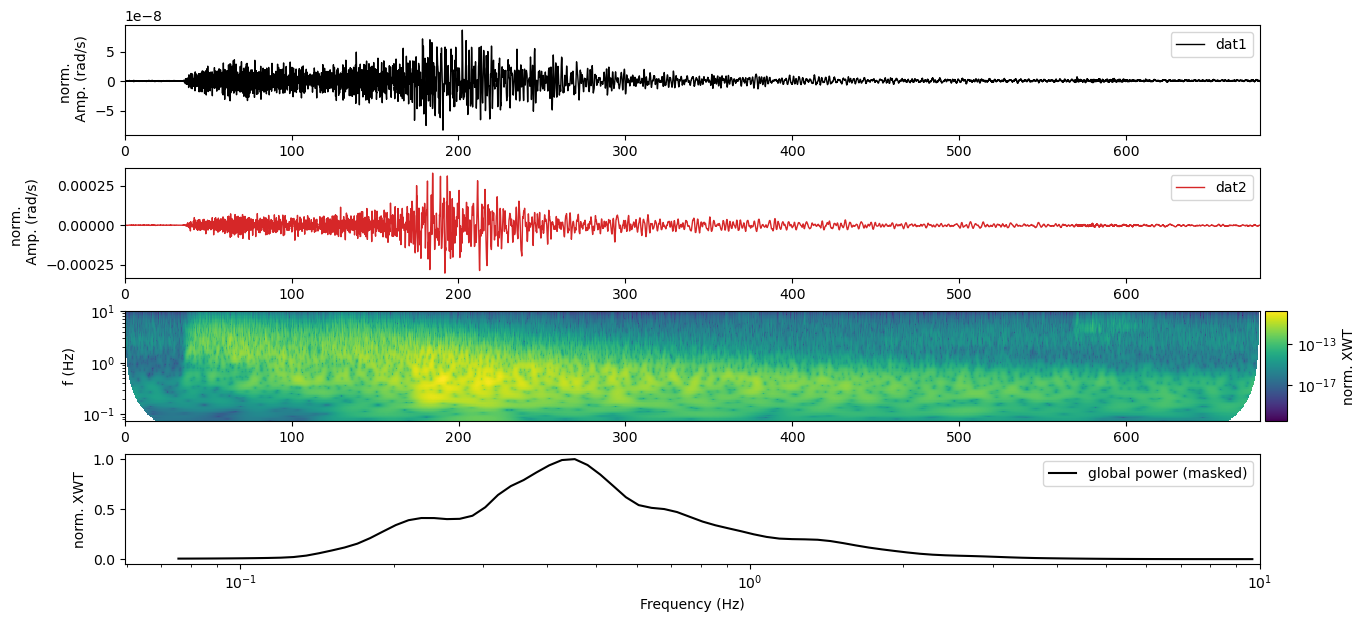

In [20]:

out = __compute_cross_wavelet_transform(
                                        rot0[0].times(),
                                        rot0.select(channel=f"*{component}")[0].data,
                                        acc0.select(channel=f"*{component}")[0].data,
                                        rot0[0].stats.delta,
                                        xwt_threshold=0.,
                                        ymax=10,
                                        normalize=False,
                                        ylog=True,
                                        clog=True,
                                        plot=True,
)

out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_xwt_{component}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (10) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


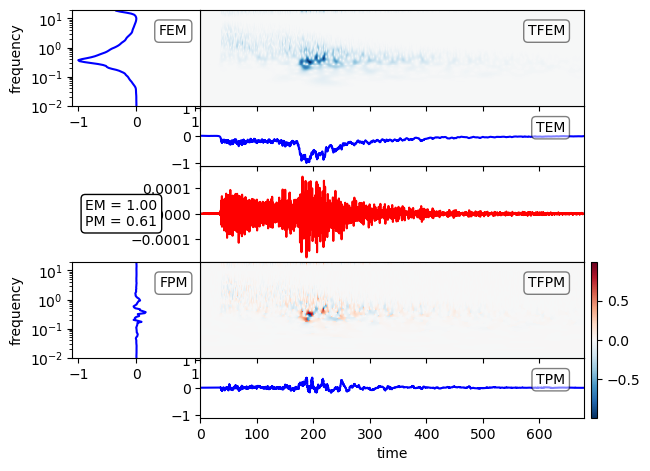

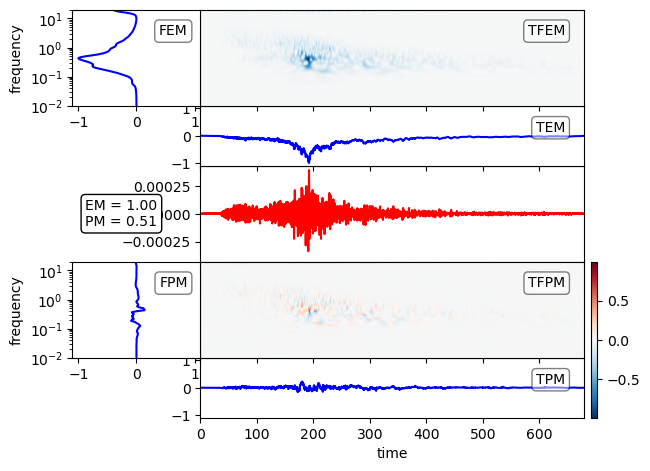

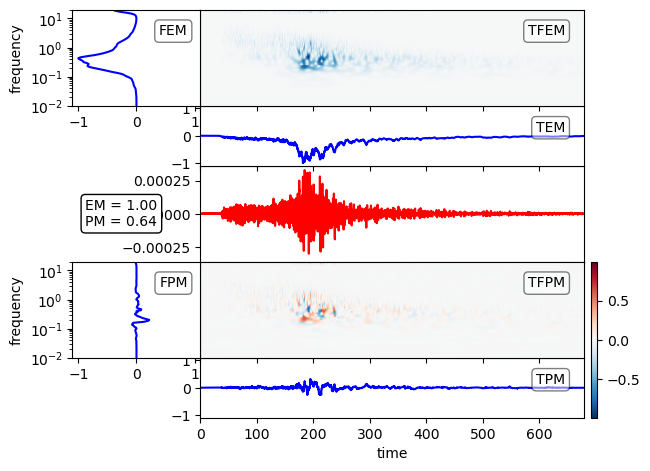

In [19]:
from scipy.signal import hilbert
from obspy.signal.tf_misfit import plot_tf_misfits

for component in ["Z", "N", "E"]:

    st1 = st0.copy()

    st1 = st1.detrend("demean").taper(0.01, type="cosine").filter("bandpass", freqmin=0.01, freqmax=10, corners=4, zerophase=True)

    s1 = st1.select(station="ROMY", channel=f"*{component}")[0].data
    s2 = st1.select(station="FUR", channel=f"*{component}")[0].data

    plot_tf_misfits(s1, s2, dt=st1[0].stats.delta, fmin=0.01, fmax=20, show=True, norm="global")


## Filter

In [ ]:

fmin, fmax = 0.005, 0.1

rot1 = st0.select(station="ROMY", channel="*J*").copy()
acc1 = st0.select(station="FUR*", channel="*H*").copy()

rot1 = rot1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);
acc1 = acc1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);


## Waveform Comparison

In [ ]:
for tr in acc1:
    if "Z" in tr.stats.channel:
        tr.data *= -1

fig = __makeplot_waveform_comparison_cc(rot1, acc1, baz, fmin, fmax, dist, twin_sec=15, twin_overlap=0.5)

fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms_cc.png", format="png", dpi=150, bbox_inches='tight');


In [ ]:
fig = __makeplot_comparison_ccf(rot1, acc1, baz, dist, twin_sec=10, twin_overlap=0.5, fmin=fmin, fmax=fmax)

## Backazimuth

In [ ]:
from functions.compute_backazimuth import __compute_backazimuth
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [ ]:
config['station_longitude'] = config['ROMY_lon']
config['station_latitude']  = config['ROMY_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 20

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 75

## specify steps for degrees of baz
config['step'] = 1


baz, az, dist = __get_theoretical_backazimuth(config['ROMY_lat'], config['ROMY_lon'], event_obj=config['event'], fdsn_client='USGS')


In [ ]:
out1 = __compute_backazimuth(
                            acc1,
                            rot1,
                            config,
                            wave_type='love',
                            event=config['event'],
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

out1['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_love_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out2 = __compute_backazimuth(
                            acc1,
                            rot1,
                            config,
                            wave_type='rayleigh',
                            event=config['event'],
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

out2['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_rayleigh_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out3 = __compute_backazimuth_tangent(
                                    rot1,
                                    acc1,
                                    win_time_s=config['win_length_sec'],
                                    overlap=config['overlap']/100,
                                    baz_theo=baz,
                                    cc_thres=0.1,
                                    plot=True,
                                    invert_acc_z=False,
                                    )

out3['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_tangent_{rot1[0].stats.station}{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


In [ ]:
out4 = __compare_backazimuth_codes(rot1, acc1, config['event'], fmin, fmax,
                                   config['win_length_sec'], config['overlap'],
                                   cc_thres=0.2, invert_acc_z=False, invert_rot_z=False, plot=True,
                                  );

out4['fig3'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_comparison_{rot1[0].stats.location}_{fmin}_{fmax}_all.png", dpi=150, bbox_inches='tight', pad_inches=0.05);


## Phase Velocity

In [ ]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [ ]:
out = __compute_velocity_from_amplitude_ratio(
                                                rot1,
                                                acc1,
                                                baz=baz,
                                                mode='love',
                                                win_time_s=config['win_length_sec'],
                                                cc_thres=0.5,
                                                overlap=config['overlap']/100,
                                                flim=(fmin, fmax),
                                                plot=True,
)

# out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_velocity_love_{rot1[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


out = __compute_velocity_from_amplitude_ratio(
                                                rot1,
                                                acc1,
                                                baz=baz,
                                                mode='rayleigh',
                                                win_time_s=config['win_length_sec'],
                                                cc_thres=0.5,
                                                overlap=config['overlap']/100,
                                                flim=(fmin, fmax),
                                                plot=True,
)

# out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_velocity_rayleigh_{rot1[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


### Velocity in F-Bands

In [ ]:
from functions.estimate_velocity_in_fbands import __estimate_velocity_in_fbands

In [ ]:
fig1, fig2 = __estimate_velocity_in_fbands(rot0, acc0, baz)


# fig1.savefig(config['path_to_figs']+f"BSFP_M42_Love_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

# fig2.savefig(config['path_to_figs']+f"BSFP_M42_Rayleigh_velocity_fbands_{rot[0].stats.station}_{rot[0].stats.location}.png", format="png", dpi=200, bbox_inches='tight')

## BAZ in F-Bands ??

In [ ]:
def __estimate_baz_in_fbands():

    # flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="one-third-octave", plot=False)
    flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="octave", plot=False)
    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0)]

    backazis = []
    flabels = []

    angles = np.arange(0, 365, 5)

    for fmin, fmax in fbands:

        print(fmin, fmax)

        acc = st0.select(station="PFO").copy();
        rot = st0.select(station="BSPF").copy();
        # rot = st0.select(station="RPFO").copy();

        rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);
        acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);

        win_time_s = 1/fmin
        cc_threshold = 0.2
        overlap = 0.9



        out3 = __compute_backazimuth_tangent(
                                            rot,
                                            acc,
                                            win_time_s=win_time_s,
                                            overlap=overlap,
                                            baz_theo=None,
                                            cc_thres=cc_threshold,
                                            plot=False,
        )


        if len(out3['baz_est']) > 0:
            hist = np.histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=(out3['ccoef']*100).astype(int), density=False)
            dat = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip( hist[0], hist[1])], axis=0 )
            backazis.append(dat)
            flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")
        else:
            print(f"empty results")


    fig, ax = plt.subplots(1, 1, figsize=(15,5))


    ax.yaxis.grid(True)

    ax.violinplot(backazis, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=flabels)

    ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    ax.set_ylim(0, 360)

    # fig.savefig(config['path_to_figs']+f"BSFP_Rayleigh_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

    plt.show();

# __estimate_baz_in_fbands()